<a href="https://colab.research.google.com/github/offthetab/GANS/blob/main/Conditional_DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download at first and restart kernel if needed
%%capture
!pip install torchinfo
!pip install torchvision==0.19.0

In [ ]:
import random
import torch as th
import numpy as np

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, Compose, Normalize
from torchinfo import summary


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
train_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

train_MNIST = datasets.MNIST('./data', download = True, train = True, transform=train_transform)
test_MNIST = datasets.MNIST('./data', download = True, train = False, transform=ToTensor())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16043608.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 458132.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3912590.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5069326.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define dataloaders to get batches
batch_size = 128
train_loader = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
# torch.Size([32, 1, 28, 28] BCHW
train_batch, train_labels = next(iter(train_loader))
train_batch.shape, train_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Conditional DCGAN

### We will input labels into generator and discriminator as embedding vectors.
[Source](https://arxiv.org/pdf/1411.1784)

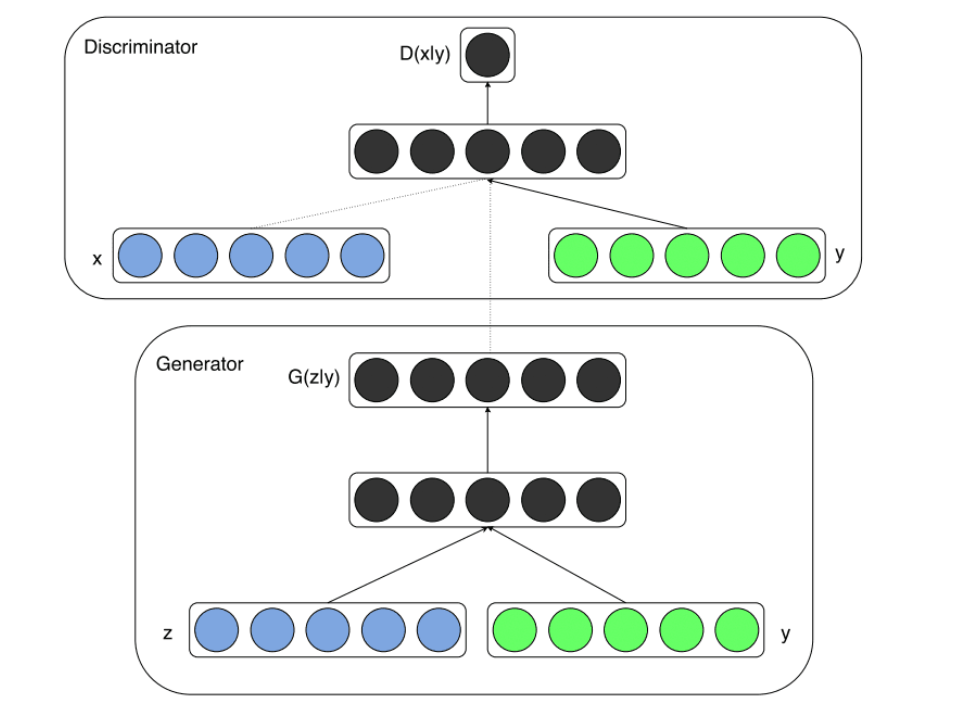

In [ ]:
class Generator(th.nn.Module):  # Has to generate fake images that are as similar to real ones as possible from random noise.
    def __init__(self, nc: int = 1, latent_size: int = 100, ngc: int = 64, num_classes: int = 10, img_size: int = 28, embed_size: int = 10):
        super(Generator, self).__init__()
        self.embed = th.nn.Embedding(num_classes, embed_size)

        self.main = th.nn.Sequential(
            # in: batch_size x latent_size + embed_size x 1 x 1

            th.nn.ConvTranspose2d(in_channels=latent_size + embed_size, out_channels=ngc * 4, kernel_size=(3, 3), stride=(3, 3), bias=False),
            th.nn.BatchNorm2d(ngc * 4),
            th.nn.ReLU(inplace=True),
            # out: 256x7x7

            th.nn.ConvTranspose2d(in_channels=ngc * 4, out_channels=ngc * 2, kernel_size=(3, 3), stride=(3, 3), padding=(1,1), bias=False),
            th.nn.BatchNorm2d(ngc * 2),
            th.nn.ReLU(inplace=True),
            # out: 128x7x7

            th.nn.ConvTranspose2d(in_channels=ngc * 2, out_channels=ngc, kernel_size=(4, 4), stride=(2, 2), padding=(1,1), bias=False),
            th.nn.BatchNorm2d(ngc),
            th.nn.ReLU(inplace=True),
            # out: 64x14x14

            th.nn.ConvTranspose2d(in_channels=ngc, out_channels=nc, kernel_size=(4, 4), stride=(2, 2), padding=(1,1), bias=False),
            # out: 1x28x28

            th.nn.Tanh()
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3) # batch_size x embed_size x 1 x 1
        x = th.cat([x, embedding], dim=1)
        return self.main(x)

In [ ]:
class Discriminator(th.nn.Module):  # Has to spot fake and real images
    def __init__(self, nc: int = 1, ndc: int = 64, num_classes: int = 10, img_size: int = 28):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.embed = th.nn.Embedding(num_classes, img_size*img_size)
        self.main = th.nn.Sequential(
            # in: image 1x28x28
            th.nn.Conv2d(in_channels=nc + 1, out_channels=ndc, kernel_size=(4, 4), stride=(2, 2), padding=(1,1), bias=False),
            th.nn.BatchNorm2d(ndc),
            th.nn.LeakyReLU(0.2, inplace=True),
            # out: 64x14x14

            th.nn.Conv2d(in_channels=ndc, out_channels=ndc*2, kernel_size=(4, 4), stride=(2, 2), padding=(1,1), bias=False),
            th.nn.BatchNorm2d(ndc*2),
            th.nn.LeakyReLU(0.2, inplace=True),
            # out: 128x7x7

            th.nn.Conv2d(in_channels=ndc*2, out_channels=ndc*4, kernel_size=(3, 3), stride=(3, 3), padding=(1,1), bias=False),
            th.nn.BatchNorm2d(ndc*4),
            th.nn.LeakyReLU(0.2, inplace=True),
            # out: 256x3x3

            th.nn.Conv2d(in_channels=ndc*4, out_channels=1, kernel_size=(3, 3), stride=(3, 3), bias=False),
            # out: 1x1x1

            th.nn.Flatten(),
            th.nn.Sigmoid()
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size) # creating additional channel for label
        x = th.cat([x, embedding], dim=1)
        return self.main(x)

In [ ]:
class WeightInit():
    def ConvInit(self, layer):
        if isinstance(layer, (th.nn.Conv2d, th.nn.ConvTranspose2d, th.nn.Linear)):
            th.nn.init.xavier_uniform_(layer.weight)
            # th.nn.init.zeros_(layer.bias)

In [ ]:
latent_size = 100  # Z or latent space

device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
generator = Generator(nc=1, latent_size=latent_size, ngc=64, num_classes=10, img_size=28, embed_size=10).to(device)
discriminator = Discriminator(nc=1, ndc=64, num_classes=10, img_size=28).to(device)

# weight initialization
weightinit = WeightInit()
generator.apply(weightinit.ConvInit)
discriminator.apply(weightinit.ConvInit)

device

device(type='cuda', index=0)

## Training cDCGAN

In [ ]:
def train_discriminator(real_images, labels, opt_d):
    opt_d.zero_grad()

    # Pass real images into discriminator
    real_targets = th.ones(real_images.size(0), 1, device=device)

    real_preds = discriminator(real_images, labels)
    real_loss = th.nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = th.mean(real_preds).item()

    # Generate fake images
    with th.no_grad():
      latent = th.randn(batch_size, latent_size, 1, 1, device=device)
      fake_images = generator(latent, labels)

    # Pass fake images into discriminator
    fake_targets = th.zeros(fake_images.size(0), 1, device=device)

    fake_preds = discriminator(fake_images, labels)
    fake_loss = th.nn.functional.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = th.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return round(loss.item(), 3), round(real_score, 3), round(fake_score, 3)

In [ ]:
def train_generator(labels, opt_g):
    opt_g.zero_grad()

    # Generate fake images
    latent = th.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent, labels)

    # Try to fool the discriminator (we label fake images as real ones, thats why labels are 1)
    preds = discriminator(fake_images, labels)
    targets = th.ones(batch_size, 1, device=device)
    loss = th.nn.functional.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return round(loss.item(), 3)

In [ ]:
def fit(epochs, lr):
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = th.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = th.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in tqdm(range(epochs)):
        for real_images, labels in train_loader:
            real_images = real_images.to(device)
            labels = labels.to(device)

            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, labels, opt_d)
            # Train generator
            loss_g = train_generator(labels, opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f"Epoch: {epoch+1}, loss_g: {loss_g}, loss_d: {loss_d}, D(x): {real_score}, D(G(z)): {fake_score}")

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 25
lr = 0.0002
history = fit(epochs, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1, loss_g: 1.844, loss_d: 0.652, D(x): 0.755, D(G(z)): 0.273
Epoch: 2, loss_g: 1.027, loss_d: 0.845, D(x): 0.561, D(G(z)): 0.167
Epoch: 3, loss_g: 2.214, loss_d: 1.105, D(x): 0.816, D(G(z)): 0.558
Epoch: 4, loss_g: 1.116, loss_d: 1.014, D(x): 0.654, D(G(z)): 0.404
Epoch: 5, loss_g: 0.922, loss_d: 1.119, D(x): 0.547, D(G(z)): 0.363
Epoch: 6, loss_g: 1.308, loss_d: 1.083, D(x): 0.678, D(G(z)): 0.472
Epoch: 7, loss_g: 0.972, loss_d: 1.164, D(x): 0.569, D(G(z)): 0.42
Epoch: 8, loss_g: 1.451, loss_d: 1.035, D(x): 0.624, D(G(z)): 0.398
Epoch: 9, loss_g: 1.042, loss_d: 1.061, D(x): 0.642, D(G(z)): 0.428
Epoch: 10, loss_g: 1.423, loss_d: 0.899, D(x): 0.702, D(G(z)): 0.391
Epoch: 11, loss_g: 0.501, loss_d: 1.176, D(x): 0.436, D(G(z)): 0.243
Epoch: 12, loss_g: 1.041, loss_d: 0.985, D(x): 0.522, D(G(z)): 0.236
Epoch: 13, loss_g: 0.976, loss_d: 0.975, D(x): 0.649, D(G(z)): 0.38
Epoch: 14, loss_g: 1.043, loss_d: 0.945, D(x): 0.595, D(G(z)): 0.311
Epoch: 15, loss_g: 0.827, loss_d: 0.994, D(x)

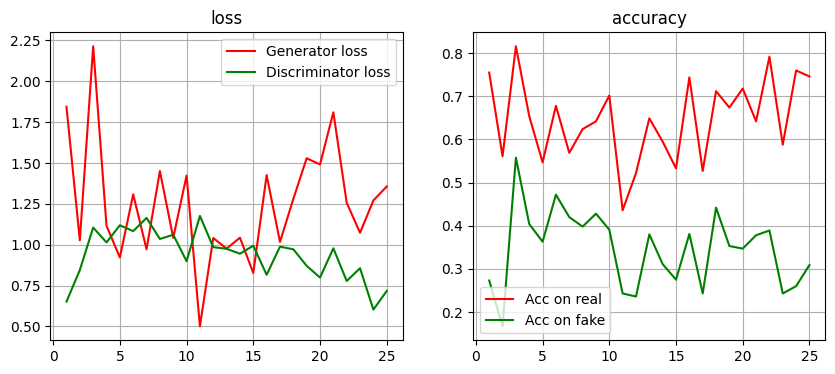

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history
epochs_ = np.arange(1, epochs+1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(epochs_, losses_g, color='red', label='Generator loss')
ax[0].plot(epochs_, losses_d, color='green', label='Discriminator loss')
ax[0].set_title("loss")
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs_, real_scores, color='red', label='Acc on real')
ax[1].plot(epochs_, fake_scores, color='green', label='Acc on fake')
ax[1].set_title("accuracy")
ax[1].legend()
ax[1].grid()

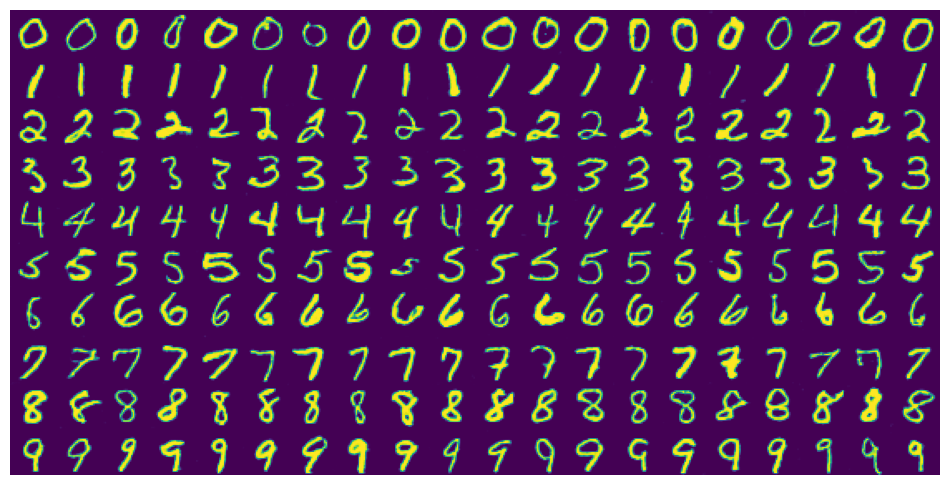

In [ ]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n * 2))
generator.eval()
with th.no_grad():
  for i in range(n):
      for j in range(n * 2):
          latent_ = th.randn(1, latent_size, 1, 1, device=device)
          labels_ = th.full((1,), i, device=device)
          generated_images = generator(latent_, labels_)
          digit = generated_images[0].cpu().numpy().reshape(digit_size, digit_size)
          figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 16))
plt.imshow(figure)
plt.axis('off')
plt.show()